In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-image-dataset


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

import torch

print(torch.cuda.is_available())  # باید True باشه

True


In [3]:
import os
root_dir = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

classes_name = ['Arborio', "Basmati", "Ipsala", "Jasmine", "Karacadag"]

images_name = []
images_label = []

for cls_index, cls_name in enumerate(classes_name):

    for img_name in os.listdir(os.path.join(root_dir, cls_name)):

        if not img_name.endswith(".jpg"):
            continue


        images_name.append(os.path.join(cls_name, img_name))
        images_label.append(cls_index)

print("Image Count: ", len(images_name))
print("Labels count: ", len(images_label))

Image Count:  75000
Labels count:  75000


In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, images_path, labels, transform=transform):
        self.images_path = images_path
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(root_dir, self.images_path[idx]))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
from sklearn.model_selection import train_test_split

train_images, temp_images, train_labels, temp_labels = train_test_split(images_name, images_label, test_size=0.2, random_state=42)

val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.1, random_state=42)

print(len(train_images))
print(len(val_images))
print(len(test_images))

60000
13500
1500


In [7]:
from torch.utils.data import DataLoader

train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)
test_dataset = CustomDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [8]:
from torchvision.models import densenet201
import torch
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = densenet201()

model.classifier = nn.Linear(model.classifier.in_features, len(classes_name))

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
NUM_EPOCHS = 20

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_func(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = train_correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    val_loss = 0.0
    val_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_func(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = val_correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)
    epochs.append(epoch + 1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_acc:.4f}")

print("Finished Training")

Epoch 1/20 | Train Loss: 0.1567, Acc: 0.9459 | Val Loss: 0.0588, Acc: 0.9818
Epoch 2/20 | Train Loss: 0.0406, Acc: 0.9877 | Val Loss: 0.0362, Acc: 0.9874
Epoch 3/20 | Train Loss: 0.0309, Acc: 0.9910 | Val Loss: 0.0209, Acc: 0.9929
Epoch 4/20 | Train Loss: 0.0249, Acc: 0.9928 | Val Loss: 0.0313, Acc: 0.9890
Epoch 5/20 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0172, Acc: 0.9945


KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), 'densenet201_rice.pth')

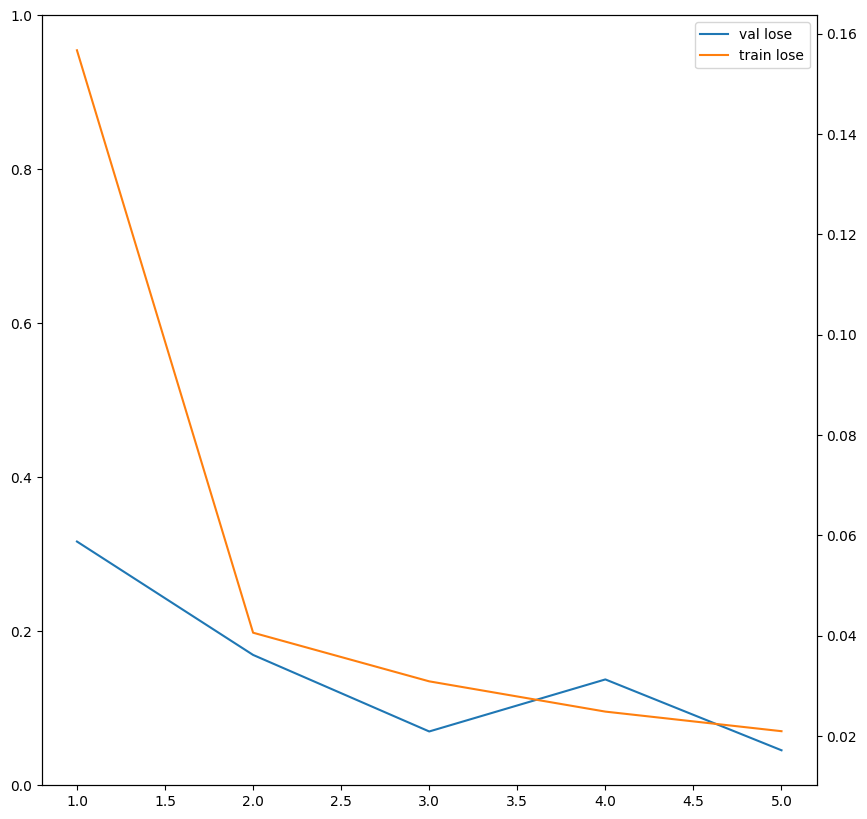

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.twinx()

plt.plot(epochs, val_losses, label="val lose")
plt.plot(epochs, train_losses, label="train lose")
plt.legend()
plt.show()

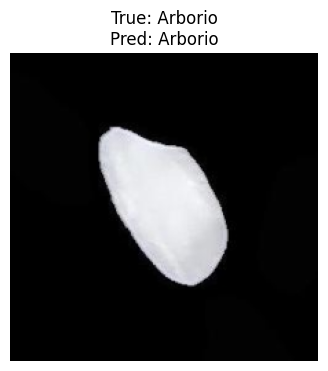

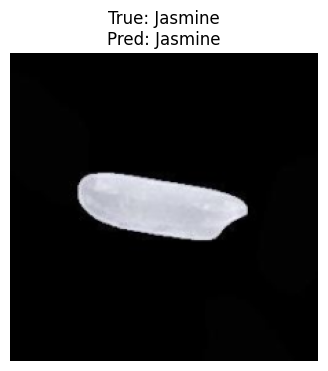

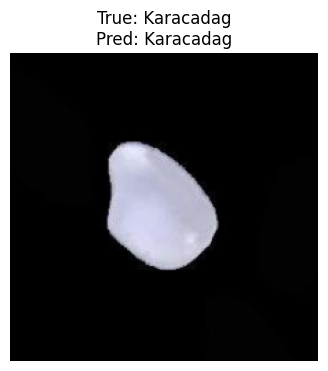

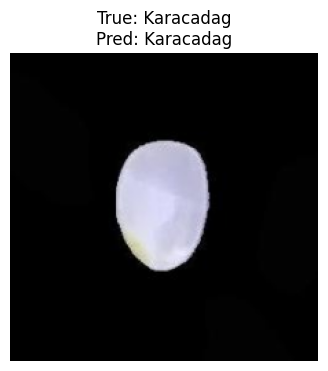

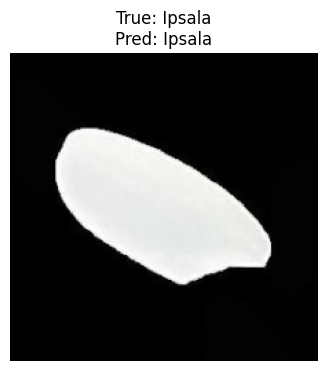

In [13]:
model.eval()

# گرفتن یک batch از test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

with torch.no_grad():
    for i in range(5):  # نمایش ۱۰ تصویر
        image = images[i].to(device)
        label = labels[i].to(device)


        input_tensor = image.unsqueeze(0)

        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        true_label = label.item()


        img_show = image.cpu().permute(1, 2, 0)

        plt.figure(figsize=(4, 4))
        plt.imshow(img_show)
        plt.title(f"True: {classes_name[true_label]}\nPred: {classes_name[pred]}")
        plt.axis('off')
        plt.show()

In [14]:

model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

In [16]:
from sklearn.metrics import classification_report


print(classification_report(true_labels, pred_labels, target_names=classes_name))

              precision    recall  f1-score   support

     Arborio       1.00      0.97      0.99       310
     Basmati       1.00      0.99      0.99       293
      Ipsala       1.00      1.00      1.00       324
     Jasmine       0.99      1.00      0.99       291
   Karacadag       0.97      1.00      0.99       282

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

